In [15]:
from pybaseball import statcast
import pandas as pd
from unidecode import unidecode
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import collections

pd.set_option('display.max_columns', 100)

#dataset will be opening day until now, pybaseball to retrieve pitch-level statcast data
df_statcast = statcast('2023-03-30', '2023-04-10')

This is a large query, it may take a moment to complete


100%|██████████| 12/12 [00:32<00:00,  2.71s/it]


In [16]:
print(df_statcast.head(1))

     pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
2608         CH 2023-04-10           86.4          -1.85           5.97   

         player_name  batter  pitcher     events      description  spin_dir  \
2608  Jackson, Andre  669369   656578  strikeout  swinging_strike      <NA>   

      spin_rate_deprecated  break_angle_deprecated  break_length_deprecated  \
2608                  <NA>                    <NA>                     <NA>   

      zone                                  des game_type stand p_throws  \
2608    13  Bryce Johnson strikes out swinging.         R     L        R   

     home_team away_team type  hit_location bb_type  balls  strikes  \
2608        SF       LAD    S             2     NaN      0        2   

      game_year  pfx_x  pfx_z  plate_x  plate_z  on_3b  on_2b  on_1b  \
2608       2023  -1.45   0.28    -1.42     1.88   <NA>   <NA>   <NA>   

      outs_when_up  inning inning_topbot  hc_x  hc_y  tfs_deprecated  \
2608             2

In [17]:
# create a function to extract player, game, and pitch data from each row
def extract_data(row):
    player_data = pd.DataFrame({
        'player_id': row['pitcher'],
        'player_name': unidecode(row['player_name']),
        'throws': row['p_throws']
        }, index=[0])

    game_data = pd.DataFrame({
        'game_id': row['game_pk'], 
        'game_date': row['game_date'],
        'home_team_id': row['home_team'],
        'away_team_id': row['away_team'],
        }, index=[0])
    
    pitch_data = pd.DataFrame({
        'game_id': row['game_pk'],
        'at_bat_no': row['at_bat_number'],
        'pitch_of_at_bat': row['pitch_number'],
        'inning': row['inning'],
        'top_inning': (0 if row['inning_topbot'] == 'Bot' else 1),
        'pitcher_id': row['pitcher'],
        'batter_id': row['batter'],
        'velo': row['release_speed'],
        'pitch_type': row['pitch_name']
    }, index=[0])
    return player_data, game_data, pitch_data

In [18]:
# apply the function to the dataframe and create three new data tables
player_data, game_data, pitch_data = map(lambda x: pd.concat(list(x), ignore_index=True), zip(*df_statcast.apply(extract_data, axis=1)))

df_player_lookup = player_data.drop_duplicates()
df_game_lookup = game_data.drop_duplicates()
df_pitches = pitch_data

df_pitches.sort_values(by=['game_id', 'inning', 'at_bat_no', 'pitch_of_at_bat'], inplace=True)
df_pitches['pitch_no'] = df_pitches.groupby('game_id').cumcount() + 1

teams = df_game_lookup['away_team_id'].to_list()
teams = set(teams)
team_ids = {val:idx for idx, val in enumerate(teams)}

# Map names to IDs, make datetimes
df_game_lookup['game_date'] = pd.to_datetime(df_game_lookup['game_date'])
df_game_lookup['home_team_id'].replace(team_ids, inplace=True)
df_game_lookup['away_team_id'].replace(team_ids, inplace=True)

/var/folders/n4/zwrw2pr542df_fc5dzlpbr400000gn/T/ipykernel_45793/2180424044.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_game_lookup['game_date'] = pd.to_datetime(df_game_lookup['game_date'])
/var/folders/n4/zwrw2pr542df_fc5dzlpbr400000gn/T/ipykernel_45793/2180424044.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_game_lookup['home_team_id'].replace(team_ids, inplace=True)
/var/folders/n4/zwrw2pr542df_fc5dzlpbr400000gn/T/ipykernel_45793/2180424044.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


In [30]:
print(team_ids)

{'KC': 0, 'LAD': 1, 'CIN': 2, 'BOS': 3, 'COL': 4, 'MIA': 5, 'PHI': 6, 'ATL': 7, 'DET': 8, 'PIT': 9, 'AZ': 10, 'HOU': 11, 'OAK': 12, 'CHC': 13, 'STL': 14, 'NYY': 15, 'WSH': 16, 'CWS': 17, 'CLE': 18, 'TEX': 19, 'SD': 20, 'SEA': 21, 'MIL': 22, 'SF': 23, 'LAA': 24, 'TOR': 25, 'NYM': 26, 'TB': 27, 'MIN': 28, 'BAL': 29}


In [19]:
df_player_lookup.to_csv('players.csv')
df_game_lookup.to_csv('games.csv')
df_pitches.to_csv('pitches.csv')

In [20]:
def generate_pitcher_summary(start, end):
    #select games within date range
    start = datetime.strptime(start, '%Y-%m-%d')
    end = datetime.strptime(end, '%Y-%m-%d')
    print(start)

    df_valid_games = df_game_lookup.query(f"game_date >= '{start}' and game_date <= '{end}'")
    id_list = set(df_valid_games['game_id'].to_list())
    id_list = list(id_list)
    print(len(id_list))

    df_valid_pitches = df_pitches[df_pitches['game_id'].isin(id_list)]
    df_summary = pd.DataFrame()
    for pitcher_id, group in df_valid_pitches.groupby('pitcher_id'):
        #spec said fastball velocity, so I am only counting 4 and 2 seam fastballs when calculating this velo column
        fastballs = group[(group.pitch_type == '4-Seam Fastball') | (group.pitch_type == 'Sinker')]
        avg_fb_velo = fastballs['velo'].mean()
        num_pitches = len(group)
        num_games = len(group['game_id'].unique())
        pitcher_name = df_player_lookup[df_player_lookup['player_id'] == pitcher_id]['player_name'].iloc[0]

        df_group = pd.DataFrame({'pitcher_id': pitcher_id, 'pitcher_name': pitcher_name, 'n_games': num_games, 'n_pitches': num_pitches, 'velo_avg': avg_fb_velo}, index=[0])
        df_summary = pd.concat([df_summary, df_group], ignore_index=True)
    
    return df_summary

In [21]:
test_start, test_end = '2023-03-30', '2023-04-10'
df_summary = generate_pitcher_summary(test_start, test_end)
df_summary_final = df_summary.dropna()
pd.set_option('display.max_rows', 500)
print(df_summary_final)

2023-03-30 00:00:00
155
     pitcher_id           pitcher_name  n_games  n_pitches    velo_avg
0        425844          Greinke, Zack        3        246   89.878788
1        445276         Jansen, Kenley        3         62   96.316667
2        445926          Chavez, Jesse        6         75   91.060000
3        446372          Kluber, Corey        2        147   87.544444
4        448179             Hill, Rich        2        149   86.253448
5        450203        Morton, Charlie        2        185   94.362366
6        453178           Kennedy, Ian        3         41   92.161290
7        453286          Scherzer, Max        3        283   93.115672
8        455119          Martin, Chris        6         83   94.863636
9        456501          Cueto, Johnny        1         30   90.369231
10       456713             Bush, Matt        4         75   94.500000
11       458681            Lynn, Lance        2        195   91.891176
12       471911       Carrasco, Carlos        2      

In [22]:
def generate_pc_matrix(pitchdf, gamedf, end, team_id):
    end = datetime.strptime(end, '%Y-%m-%d')
    days = list(pd.date_range(end=end, periods=7, freq='D'))
    print(days)
    days.append('Last 3 Days')
    days.append('Last 7 Days')

    #join game and pitch tables to find team of each player
    #pitcher is on home team if top inning == 1, away if 0
    df_merged = pd.merge(pitchdf, gamedf, on='game_id', how='inner')
    df_merged = df_merged[((df_merged['home_team_id'] == team_id) & (df_merged['top_inning'] == 1)) | ((df_merged['away_team_id'] == team_id) & (df_merged['top_inning'] == 0))]
    player_ids = set(df_merged['pitcher_id'].to_list())
    player_ids = list(player_ids)

    df_matrix = pd.DataFrame(index=player_ids, columns=days)
    df_matrix = df_matrix.fillna(0)
    
    #for each pitcher in list: did they pitch on given day? If so, how many pitches
    df_valid_pitches = df_pitches[df_pitches['pitcher_id'].isin(player_ids)]
    for pitcher_id, group in df_valid_pitches.groupby(['pitcher_id', 'game_id']):
        row1 = group.iloc[0]
        game_date = gamedf[gamedf['game_id'] == row1['game_id']]['game_date'].iloc[0]
        game_date = datetime.strptime(game_date, '%Y-%m-%d')
        if game_date in df_matrix.columns:
            df_matrix.at[row1['pitcher_id'], game_date] = len(group)
            #else do nothing
    
    
    # # calculate sum of last 3 and last 7 values for each row
    for idx, row in df_matrix.iterrows():
        last3 = row[-5:-2].sum()
        last7 = row[-9:-2].sum()
        df_matrix.at[idx, 'Last 3 Days'] = last3
        df_matrix.at[idx, 'Last 7 Days'] = last7

    return df_matrix

In [23]:
def generate_gui_grid(df, dfplayer):
    # create a figure and axis object
    df['name'] = df.index.map(dfplayer.set_index('player_id')['player_name'])
    df = df.reindex(['name'] + list(df.columns[:-1]), axis=1)
    df.iloc[1:, 1:] = df.iloc[1:, 1:].apply(pd.to_numeric, errors='coerce')
    fig, ax = plt.subplots(1, 1, figsize=(df.shape[0], df.shape[1]))

    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
    table.set_fontsize(14)

    i = 1
    for row in df.index:
        j = 1
        four_window = collections.deque([])
        pair_window = []
        for col in df.columns[1:8]:
            # use sliding windows to capture pairs and 4-day periods
            value = df.at[row, col]
            if len(pair_window) < 2:
                pair_window.append([i, j, row, col])
            else:
                temp = pair_window[1]
                pair_window[0] = temp
                pair_window[1] = [i,j, row, col]

            if len(four_window) < 4:
                four_window.append([i, j, row, col])
            else:
                four_window.popleft()
                four_window.append(([i, j, row, col]))

            if len(pair_window) == 2 and df.at[pair_window[0][2], pair_window[0][3]] != 0 and df.at[pair_window[1][2], pair_window[1][3]] != 0:
                table.get_celld()[pair_window[0][0], pair_window[0][1]].set_facecolor('red')
                table.get_celld()[pair_window[1][0], pair_window[1][1]].set_facecolor('red')
            if len(four_window) >= 3:
                nonzeros = []
                for elt in four_window:
                    if df.at[elt[2], elt[3]] != 0:
                        nonzeros.append((elt[0], elt[1]))
                if len(nonzeros) >= 3:
                    for p in nonzeros:
                        table.get_celld()[p[0], p[1]].set_facecolor('red')
            j += 1
        i += 1


    plt.show()

   game_id   game_date  home_team_id  away_team_id
0   718641  2023-04-10            23             1
   game_id  at_bat_no  pitch_of_at_bat  inning  top_inning  pitcher_id  \
0   718627          1                1       1           1      668678   

   batter_id  velo       pitch_type  pitch_no  
0     592885  94.2  4-Seam Fastball         1  
   player_id     player_name throws
0     656578  Jackson, Andre      R
[Timestamp('2023-04-01 00:00:00', freq='D'), Timestamp('2023-04-02 00:00:00', freq='D'), Timestamp('2023-04-03 00:00:00', freq='D'), Timestamp('2023-04-04 00:00:00', freq='D'), Timestamp('2023-04-05 00:00:00', freq='D'), Timestamp('2023-04-06 00:00:00', freq='D'), Timestamp('2023-04-07 00:00:00', freq='D')]


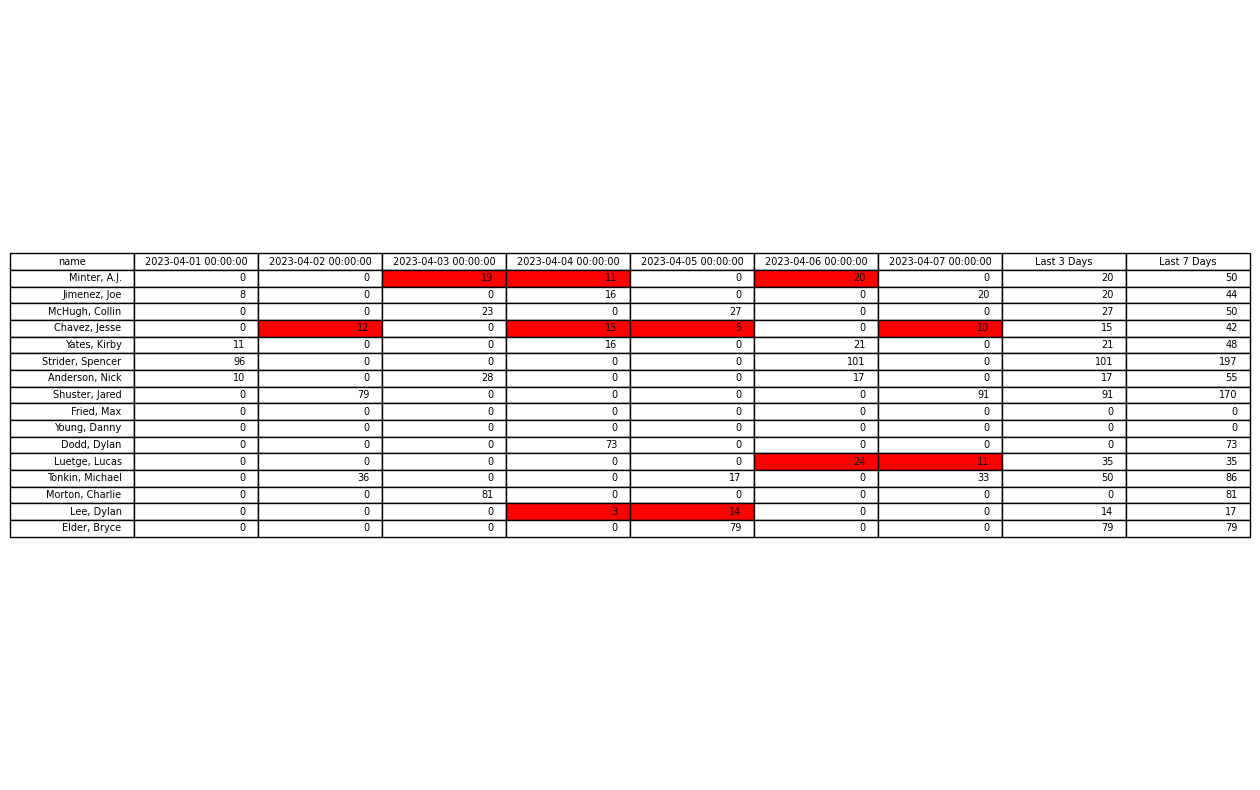

In [32]:
def partCfinal(df_p, df_gl, df_pl, end, team_id):
    #returns raw pandas dataframe along with color coded plot
    matrix = generate_pc_matrix(df_p, df_gl, end, team_id)
    grid = generate_gui_grid(matrix, df_pl)

    return matrix, grid

df_game_lookup_c = pd.read_csv('games.csv')
df_game_lookup_c = df_game_lookup_c.drop('Unnamed: 0', axis=1)


df_pitches_c = pd.read_csv('pitches.csv')
df_pitches_c = df_pitches_c.drop('Unnamed: 0', axis=1)

df_player_lookup_c = pd.read_csv('players.csv')
df_player_lookup_c = df_player_lookup_c.drop('Unnamed: 0', axis=1)


print(df_game_lookup_c.head(1))
print(df_pitches_c.head(1))
print(df_player_lookup_c.head(1))

matrix, grid = partCfinal(df_pitches_c, df_game_lookup_c, df_player_lookup_c, '2023-04-07', 7)
matrix.to_csv('Braves Output 04-07.csv')